In [2]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")
# isns.set_image(origin="upper")

import utils
import os
import glob
import random
import time
import aiofiles
import asyncio

import data_generator as dg

%matplotlib inline

2023-04-29 00:42:09.304968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/tmp/ipykernel_108915/150265179.py:3: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(img1, axis=1), axis=0)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


number of NaN:                103500
number of NaN channel 1:      34291
number of NaN channel 2:      34291
number of NaN channel 3:      34918


(256, 256, 3)

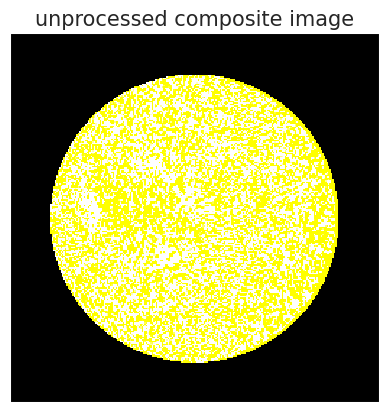

In [3]:
img1 = np.load("data/composite_data/2016-10-04T07-23-47.npy")

min_values = np.nanmin(np.nanmin(img1, axis=1), axis=0)

print("number of NaN:               ", np.count_nonzero(np.isnan(img1)))
print("number of NaN channel 1:     ", np.count_nonzero(np.isnan(img1[:,:,0])))
print("number of NaN channel 2:     ", np.count_nonzero(np.isnan(img1[:,:,1])))
print("number of NaN channel 3:     ", np.count_nonzero(np.isnan(img1[:,:,2])))

isns.imshow(img1).set(title="unprocessed composite image")
img1.shape

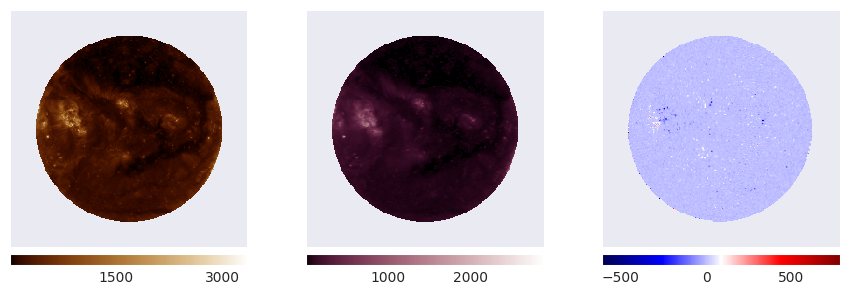

In [4]:
isns.rgbplot(img1, cmap=["sdoaia193", "sdoaia211", "seismic"], orientation="h")

In [5]:
# # Normalization needed
# min_values = np.nanmin(np.nanmin(img1, axis=1, keepdims=True), axis=0, keepdims=True)

# max_values = np.nanmax(np.nanmax(img1, axis=1, keepdims=True), axis=0, keepdims=True)

# rg = max_values - min_values

# rg = np.fmax(rg, 1e-4*np.ones(rg.shape))

# img1_norm = (img1-min_values) / rg

# img1_norm[np.isnan(img1_norm)] = 0

img1_norm = dg.MultiChannelAEGenerator.normalize(np.asarray([img1]))[0]

utils.range_tuple(img1_norm)

/home/eugeniolr/Documents/master/TFM/data_generator.py:188: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:189: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:197: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)


(0.0, 1.0)

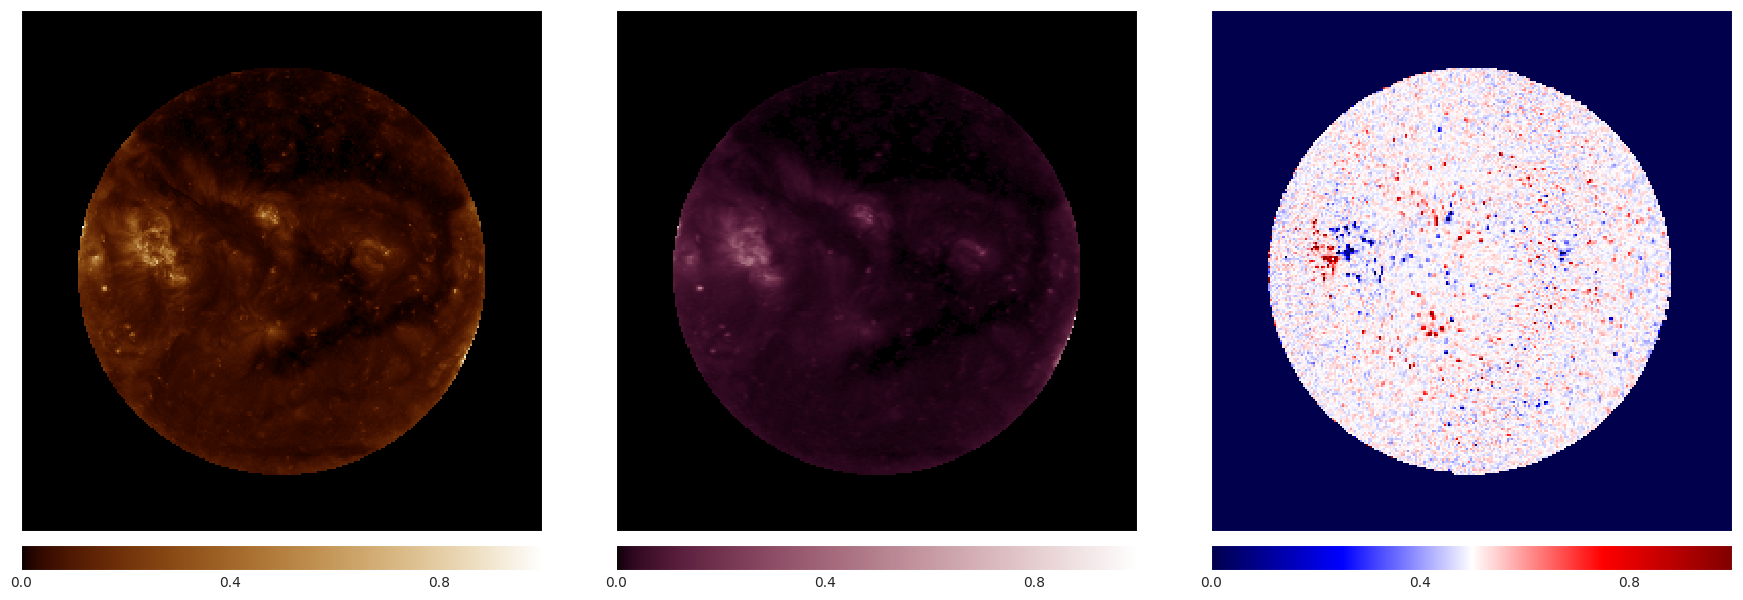

In [6]:
isns.rgbplot(img1_norm, cmap=["sdoaia193", "sdoaia211", "seismic"], orientation="h", height=6)

In [7]:
data_files_3c = glob.glob("data/composite_data/2016*.npy")

print(len(data_files_3c))

data_file_chunks = utils.chunks(data_files_3c, 1000)


data_matrix = np.empty([1000,256,256,3])
chunk1 = next(data_file_chunks)
for idx, data_file in enumerate(chunk1):
    data_matrix[idx] = np.load(data_file)

data_matrix.shape

2807


(1000, 256, 256, 3)

In [8]:
# min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)

# max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)

# rg = max_values - min_values

# rg = np.fmax(rg, 1e-4)

# data_matrix_norm = (data_matrix-min_values) / rg

# data_matrix_norm[np.isnan(data_matrix_norm)] = 0

data_matrix_norm = dg.MultiChannelAEGenerator.normalize(data_matrix)

utils.range_tuple(data_matrix_norm)

(0.0, 1.0)

<AxesSubplot: >

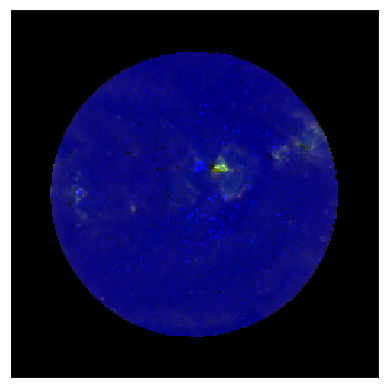

In [9]:
example_img = random.choice(data_matrix_norm)
isns.imgplot(example_img)

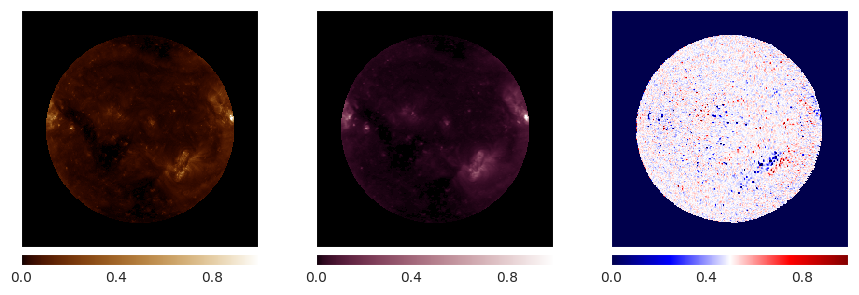

In [10]:
isns.rgbplot(random.choice(data_matrix_norm), cmap=["sdoaia193", "sdoaia211", "seismic"], orientation="h", vmin=0, vmax=1)

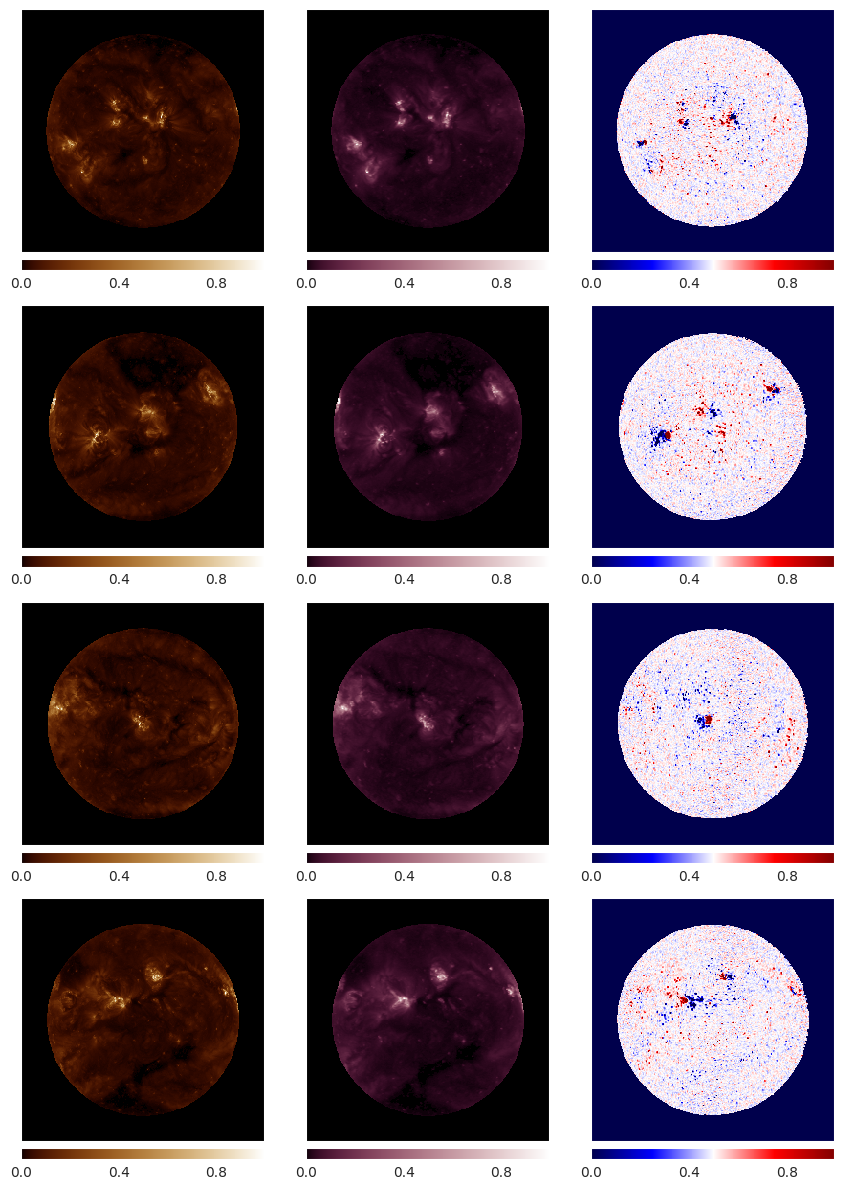

In [11]:
img_amount = 4

image_list_aux = [[i[:,:,0], i[:,:,1], i[:,:,2]] for i in random.choices(data_matrix_norm, k=img_amount)]
image_list = []
for i in image_list_aux:
    image_list += i

ax = isns.ImageGrid(image_list, col_wrap=3, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, orientation="h", vmin=0, vmax=1)
plt.tight_layout()

In [12]:
batch_size = 1
data_gen = dg.MultiChannelAEGenerator("data/composite_data/", batch_size, test_split=0.2, shuffle=True, noise_filter=True)
data_gen.take_all = True

25650
22501


In [13]:
len(data_gen)

22501

In [14]:
data_gen[0][0][0].shape

(204, 204, 3)

In [17]:
from IPython.display import clear_output, display
import ipywidgets as widgets
import time
import keyboard
import cv2

current_file = "a"
noisy = []
blocked = True


end = False

for idx, data_point in enumerate(data_gen):
    
    # isns.rgbplot(data_point[0][0], cmap=["sdoaia193", "sdoaia211", "seismic"], orientation="h")
    # plt.show()
    
    while blocked:
        if input() == 'q':
            end = True
            blocked = False
        time.sleep(0.5)
    
    if end:
        break
    
    clear_output()

#     if idx >= 3:q
#         break
# for idx, val in enumerate(data_gen):
#     print("a")

/home/eugeniolr/Documents/master/TFM/data_generator.py:188: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:189: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:197: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)


In [ ]:
noisy

['a']